# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Complementary experiments

In this jupyter notebook, we will try two complementary approaches to increase classification score - prediction cross age groups and similar samples (clusters).

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *
from sklearn.cluster import KMeans

In [4]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Load train and test data

The data from preprocessing phase will be used. Because models trained on undersampled data achieved best results in general in model selection phase, those data will be used.

In [5]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [6]:
X_train, y_train = undersample(X_train, y_train)

In [7]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 18188
Number of test data: 20353
Number of features: 53
Classes:
	0 :
	    train: 9094 samples, 50.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 50.0%
	    test: 2263 samples, 11.0%



### 1. Classification cross age

At first, we will try to train different models on 4 age groups (and in combination). Each model will be trained only on samples with appropriate age group. Models trained on different age groups can potentially discover features typical for that one age group.

#### Histogram of age classes

Histogram of age attribute helps to select age threshold for 4 age groups. Age classes have been created in preprocessing phase (check appropriate notebook if needed).

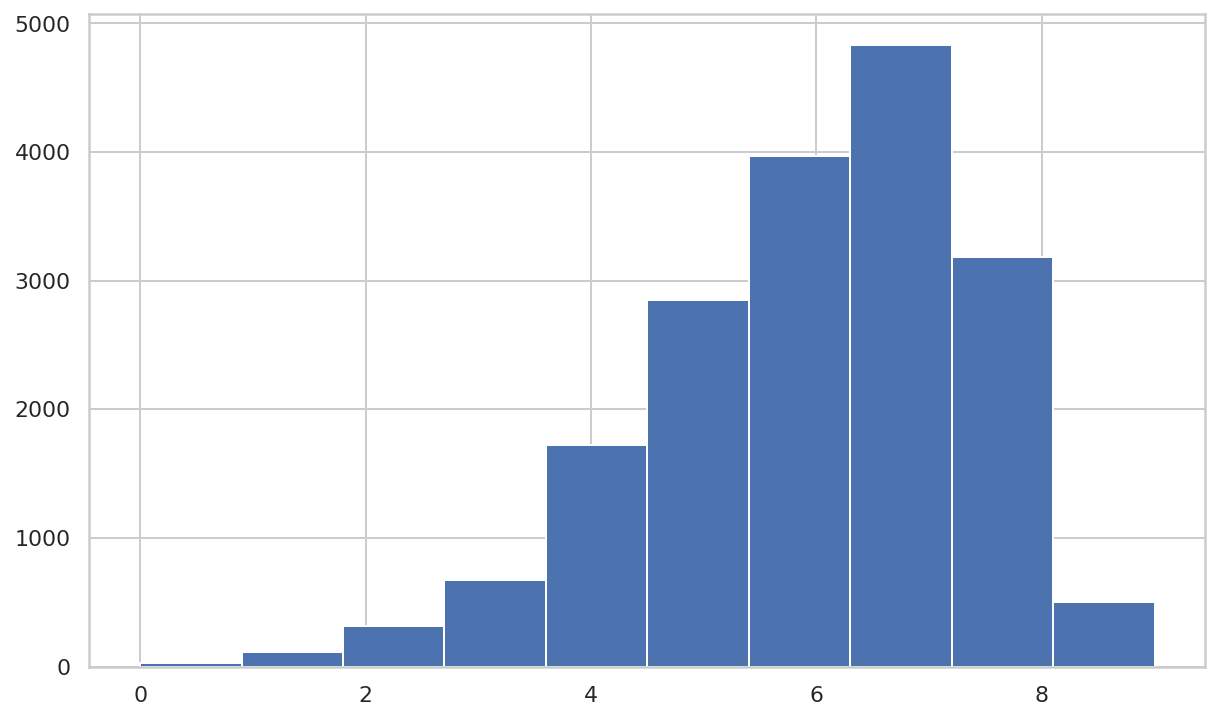

In [8]:
counts, bins = np.histogram(X_train['age'])
plt.hist(bins[:-1], bins, weights=counts);

#### Divide data into age groups

We specified intervals for age groups to obtain most accurate balanced datasets.

Groups:
* 1: age in <0, 50) -> {0, 1, 2, 3, 4}
* 2: age in <50, 70) -> {5, 6}
* 3: age in <70, 80) -> {7}
* 4: age in <80, 100) -> {8, 9}

In [9]:
def less(x, y, t):
    x_filtered = x[x['age'] < t]
    return x_filtered, y.loc[x_filtered.index]

def more(x, y, t):
    x_filtered = x[x['age'] > t]
    return x_filtered, y.loc[x_filtered.index]

In [10]:
# Group 1: <0, 50)
X_train_age_1, y_train_age_1 = less(X_train, y_train, 5)
X_test_age_1, y_test_age_1 = less(X_test, y_test, 5)

# Group 2: <50, 70)
X_train_age_2, y_train_age_2 = more(*less(X_train, y_train, 7), 4)
X_test_age_2, y_test_age_2 = more(*less(X_test, y_test, 7), 4)

# Group 3: <70, 80)
X_train_age_3, y_train_age_3 = more(*less(X_train, y_train, 8), 6)
X_test_age_3, y_test_age_3 = more(*less(X_test, y_test, 8), 6)

# Group 4: <80, 100)
X_train_age_4, y_train_age_4 = more(X_train, y_train, 7)
X_test_age_4, y_test_age_4 = more(X_test, y_test, 7)

In [11]:
print("Number of data in each age group:")
print("<0, 50): ", X_train_age_1.shape[0])
print("<50, 70): ", X_train_age_2.shape[0])
print("<70, 80): ", X_train_age_3.shape[0])
print("<80, 100):", X_train_age_4.shape[0])

Number of data in each age group:
<0, 50):  2855
<50, 70):  6816
<70, 80):  4830
<80, 100): 3687


#### Train models

We will use base model from model selection phase which obtained best results. 4 Random forest models will be used to train on all 4 age groups individually. 

##### 1. Group <0, 50)

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      2844
           1       0.17      0.54      0.26       315

    accuracy                           0.70      3159
   macro avg       0.55      0.63      0.54      3159
weighted avg       0.86      0.70      0.75      3159

ROC AUC score: 0.681


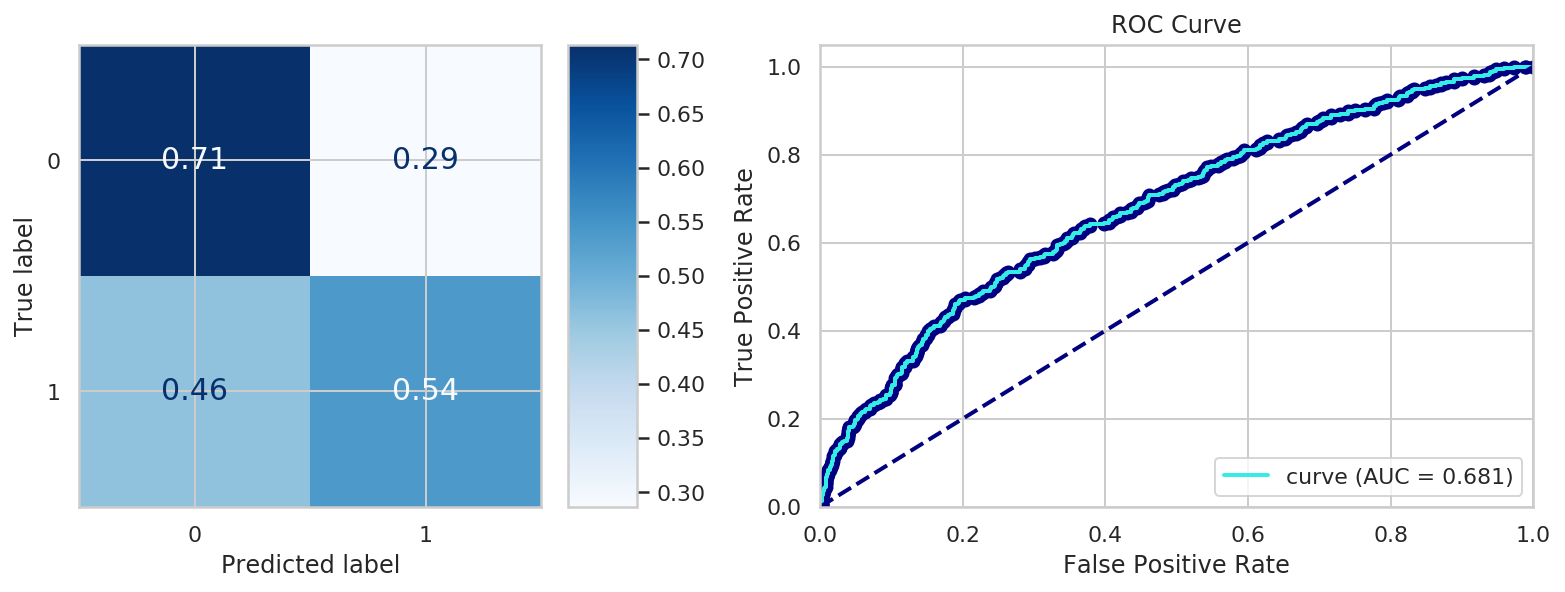

In [12]:
rf_age_1 = RandomForestClassifier(max_depth=8, random_state=42)
rf_age_1.fit(X_train_age_1, y_train_age_1)
evaluate_model(rf_age_1, X_test_age_1, y_test_age_1)

##### 2. Group <50, 70)

              precision    recall  f1-score   support

           0       0.93      0.68      0.78      7134
           1       0.18      0.57      0.28       905

    accuracy                           0.67      8039
   macro avg       0.56      0.63      0.53      8039
weighted avg       0.84      0.67      0.73      8039

ROC AUC score: 0.673


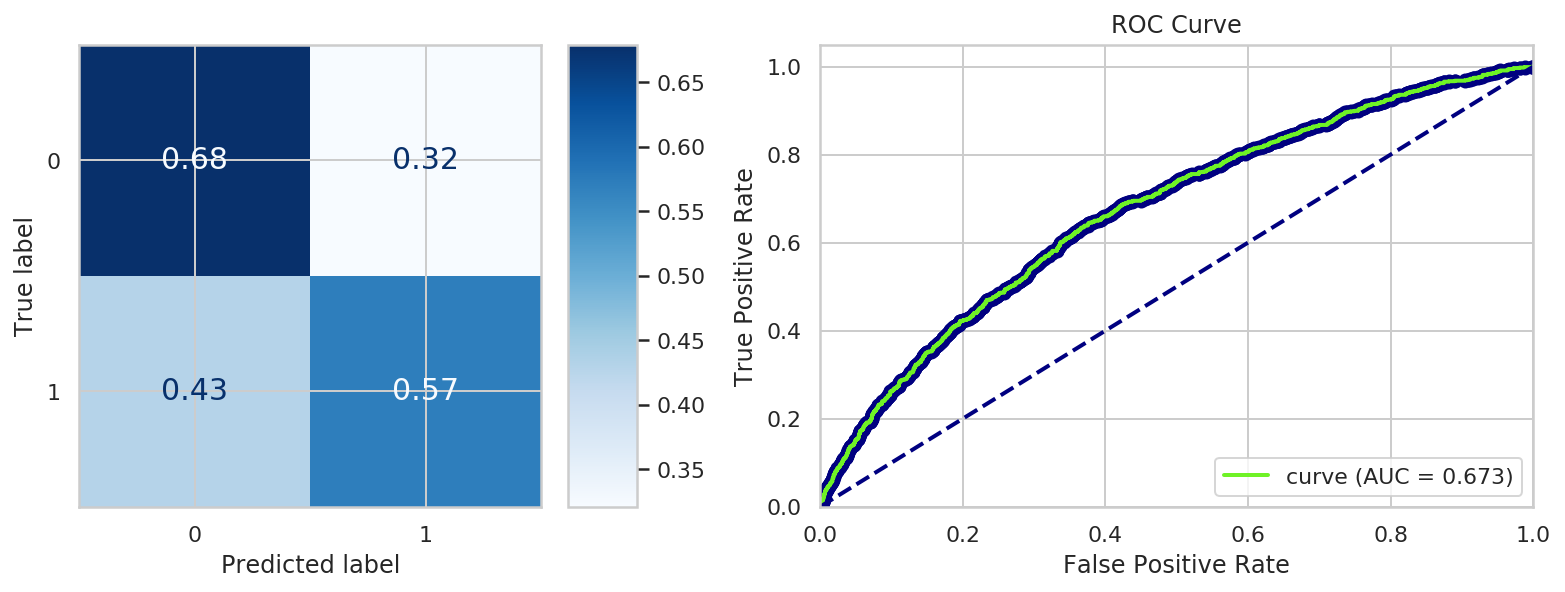

In [13]:
rf_age_2 = RandomForestClassifier(max_depth=8, random_state=42)
rf_age_2.fit(X_train_age_2, y_train_age_2)
evaluate_model(rf_age_2, X_test_age_2, y_test_age_2)

##### 3. Group <70, 80)

              precision    recall  f1-score   support

           0       0.92      0.51      0.65      4488
           1       0.15      0.67      0.25       582

    accuracy                           0.53      5070
   macro avg       0.54      0.59      0.45      5070
weighted avg       0.83      0.53      0.61      5070

ROC AUC score: 0.633


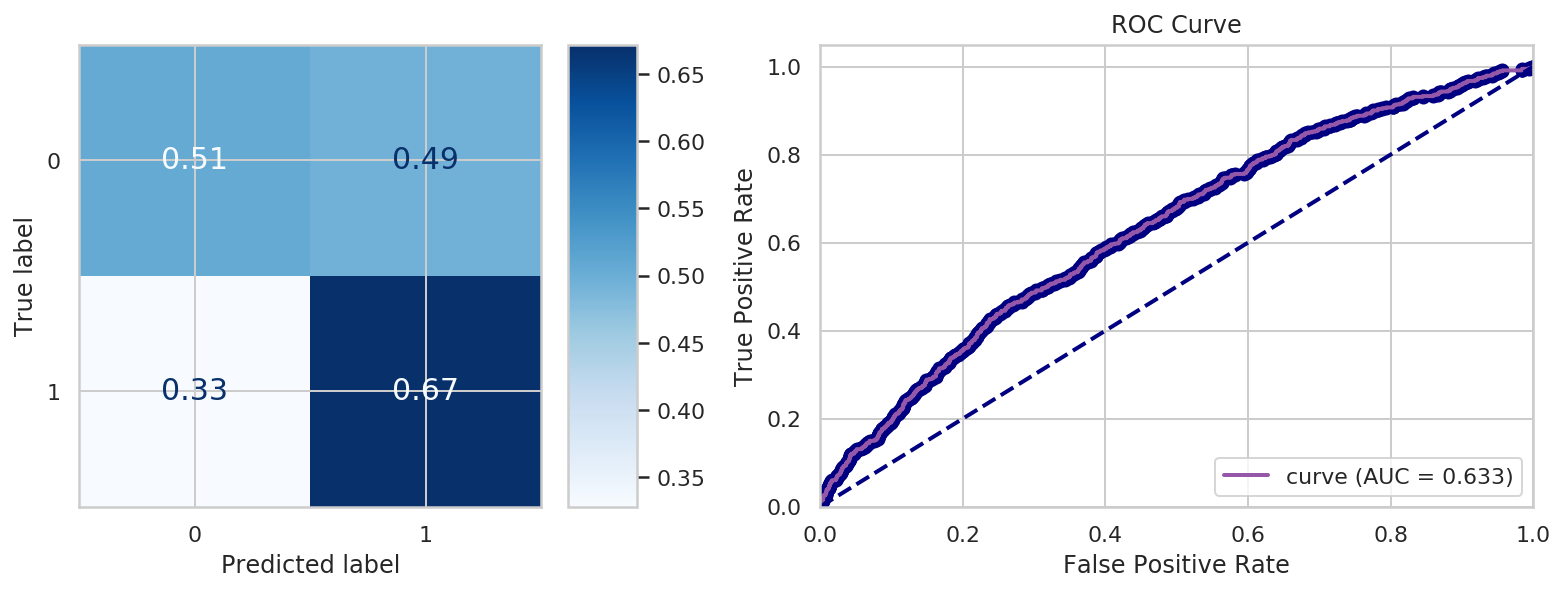

In [14]:
rf_age_3 = RandomForestClassifier(max_depth=8, random_state=42)
rf_age_3.fit(X_train_age_3, y_train_age_3)
evaluate_model(rf_age_3, X_test_age_3, y_test_age_3)

##### 4. Group <80, 100)

              precision    recall  f1-score   support

           0       0.91      0.43      0.58      3624
           1       0.13      0.67      0.22       461

    accuracy                           0.46      4085
   macro avg       0.52      0.55      0.40      4085
weighted avg       0.82      0.46      0.54      4085

ROC AUC score: 0.578


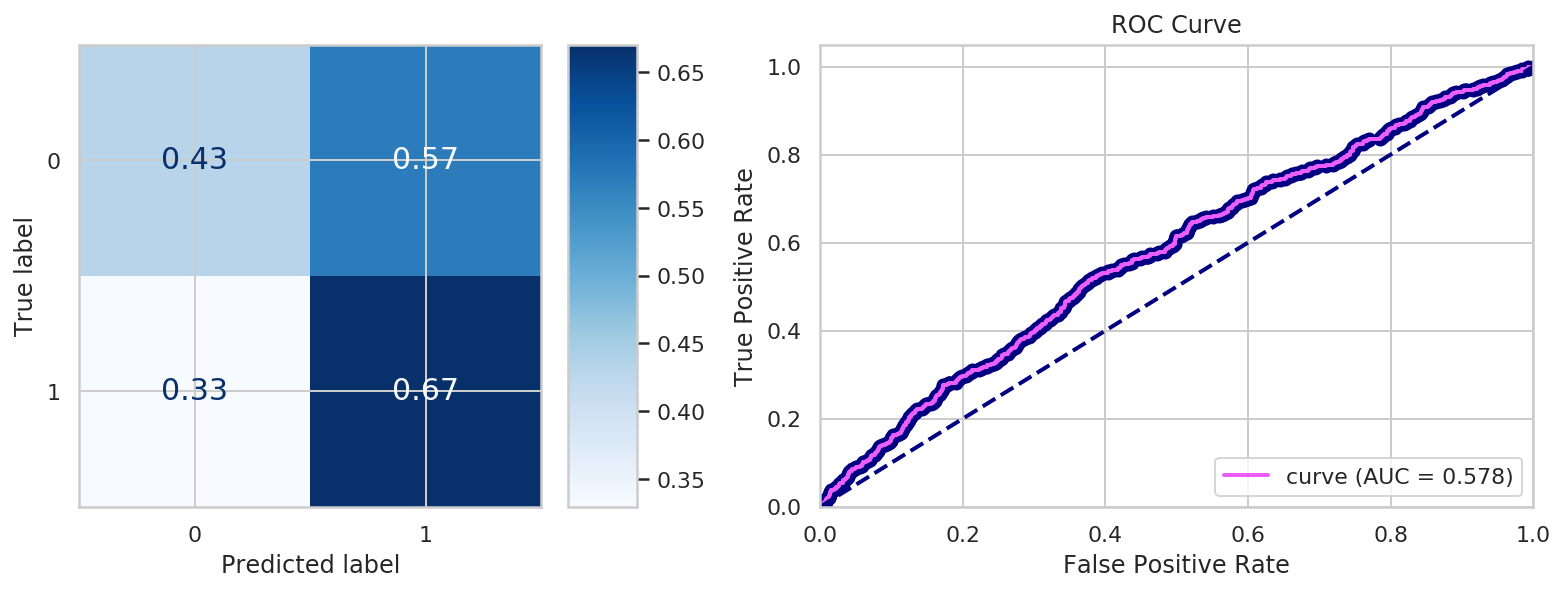

In [15]:
rf_age_4 = RandomForestClassifier(max_depth=8, random_state=42)
rf_age_4.fit(X_train_age_4, y_train_age_4)
evaluate_model(rf_age_4, X_test_age_4, y_test_age_4)

As we can see, 2 of the models are achieving significantly better results than Random forest trained on all samples (but those after undersampling). However, other two are performing worse. Will see, if combination of models can improve prediction or not.

#### Combined model

Four models will be combined into one model called CombinedModel. We created this new type of model ensemble which contains several models. During prediction from all models is selected one with rules in ruler function. In this case, for each sample in test data is selected model of apropriate age interval. Combined model can be interpreted simply as `switch`.

In [16]:
def ruler(x):
    age = x['age']
    if age <= 4:
        return 0
    elif age in (5, 6):
        return 1
    elif age == 7:
        return 2
    elif age in (8, 9):
        return 3

In [17]:
cls = CombinedModel([rf_age_1, rf_age_2, rf_age_3, rf_age_4], ruler)

In [18]:
pred = cls.predict(X_test)
pred_prob = cls.predict(X_test, probabilities=True)

              precision    recall  f1-score   support

           0       0.92      0.59      0.72     18090
           1       0.16      0.61      0.25      2263

    accuracy                           0.59     20353
   macro avg       0.54      0.60      0.49     20353
weighted avg       0.84      0.59      0.67     20353

ROC AUC score: 0.645


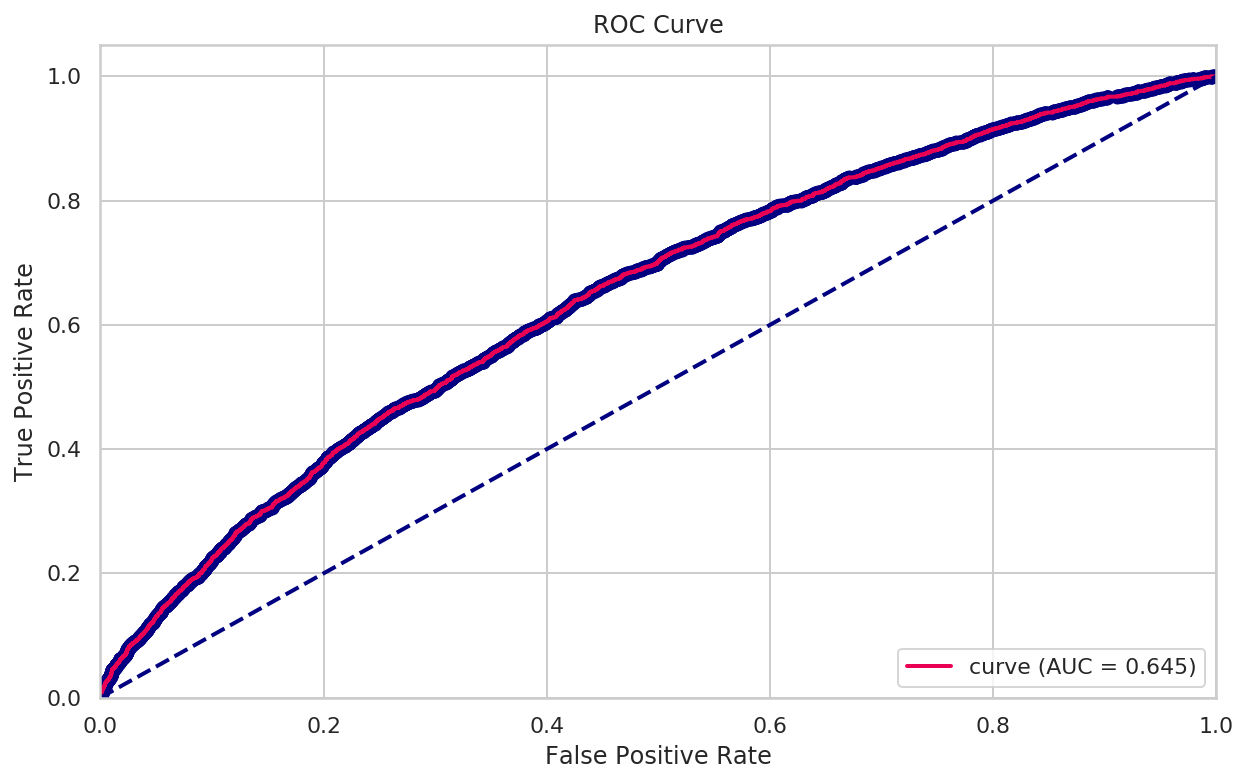

In [19]:
print(classification_report(y_test, pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, pred_prob), 3)}')
roc_auc(pred_prob, y_test);

##### Conclusion

In the first experiment we created own model ensemble by combination of four models, each trained for individual patient age range. We did not achieve better results as best model from model selection phase, but at least we made some observations. 

Results from individual age interval training showed trend, that performance of model is decreasing with increasing age. This observation was also mentioned in several related papers. For patients under 50 age and also at age from 50 to 70, models achieved significantly better results in comparison to model trained on all samples (not divided by age).

### 2. Classification cross clusters

As above data were divided with age rule, in the next experiment data will by divided to the clusters by the clustering algorithm KMeans. Within each individual cluster, one model will be trained.

#### Train KMeans and divide data to clusters

In [20]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_train)

In [21]:
clusters = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)
X_train_knn_1, y_train_knn_1 = X_train[clusters == 0], y_train[clusters == 0]
X_test_knn_1, y_test_knn_1 = X_test[clusters_test == 0], y_test[clusters_test == 0]

X_train_knn_2, y_train_knn_2 = X_train[clusters == 1], y_train[clusters == 1]
X_test_knn_2, y_test_knn_2 = X_test[clusters_test == 1], y_test[clusters_test == 1]

X_train_knn_3, y_train_knn_3 = X_train[clusters == 2], y_train[clusters == 2]
X_test_knn_3, y_test_knn_3 = X_test[clusters_test == 2], y_test[clusters_test == 2]

In [22]:
print("Number of data in each cluster group:")
print("cluster 1: ", X_train_knn_1.shape[0])
print("cluster 2: ", X_train_knn_2.shape[0])
print("cluster 3: ", X_train_knn_3.shape[0])

Number of data in each cluster group:
cluster 1:  8676
cluster 2:  6021
cluster 3:  3491


##### 1. Cluster 1

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      8648
           1       0.16      0.66      0.26      1091

    accuracy                           0.57      9739
   macro avg       0.54      0.61      0.48      9739
weighted avg       0.84      0.57      0.65      9739

ROC AUC score: 0.651


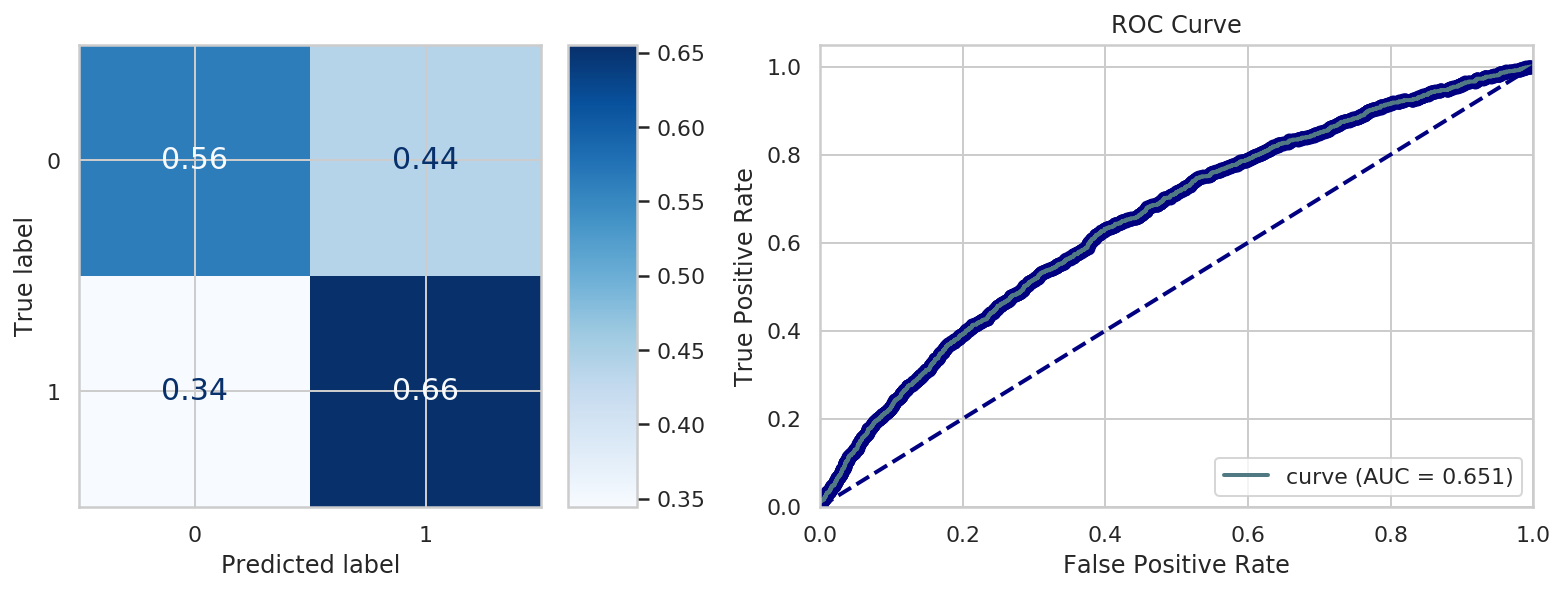

In [23]:
rf_knn_1 = RandomForestClassifier(max_depth=8, random_state=42)
rf_knn_1.fit(X_train_knn_1, y_train_knn_1)
evaluate_model(rf_knn_1, X_test_knn_1, y_test_knn_1)

##### 2. Cluster 2

              precision    recall  f1-score   support

           0       0.92      0.53      0.67      5694
           1       0.16      0.65      0.26       791

    accuracy                           0.54      6485
   macro avg       0.54      0.59      0.46      6485
weighted avg       0.82      0.54      0.62      6485

ROC AUC score: 0.628


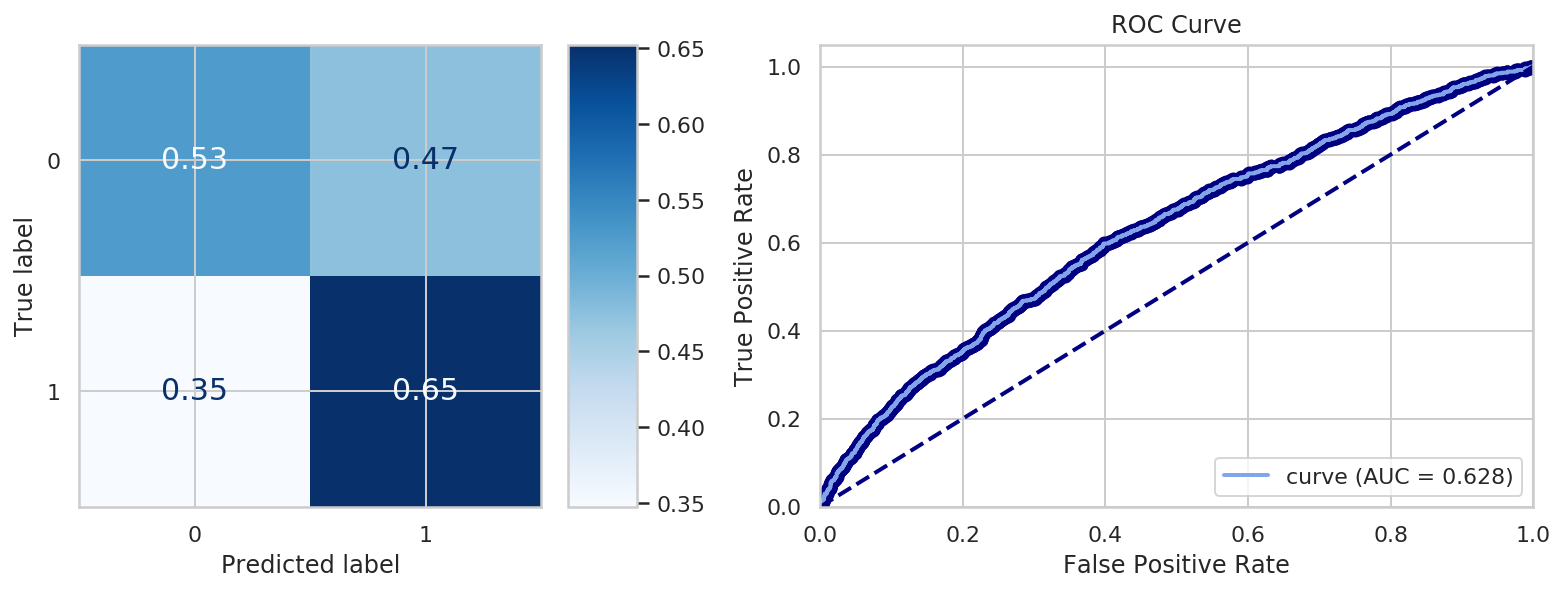

In [24]:
rf_knn_2 = RandomForestClassifier(max_depth=8, random_state=42)
rf_knn_2.fit(X_train_knn_2, y_train_knn_2)
evaluate_model(rf_knn_2, X_test_knn_2, y_test_knn_2)

##### 3. Cluster 3

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      3748
           1       0.15      0.50      0.23       381

    accuracy                           0.69      4129
   macro avg       0.54      0.61      0.52      4129
weighted avg       0.86      0.69      0.75      4129

ROC AUC score: 0.66


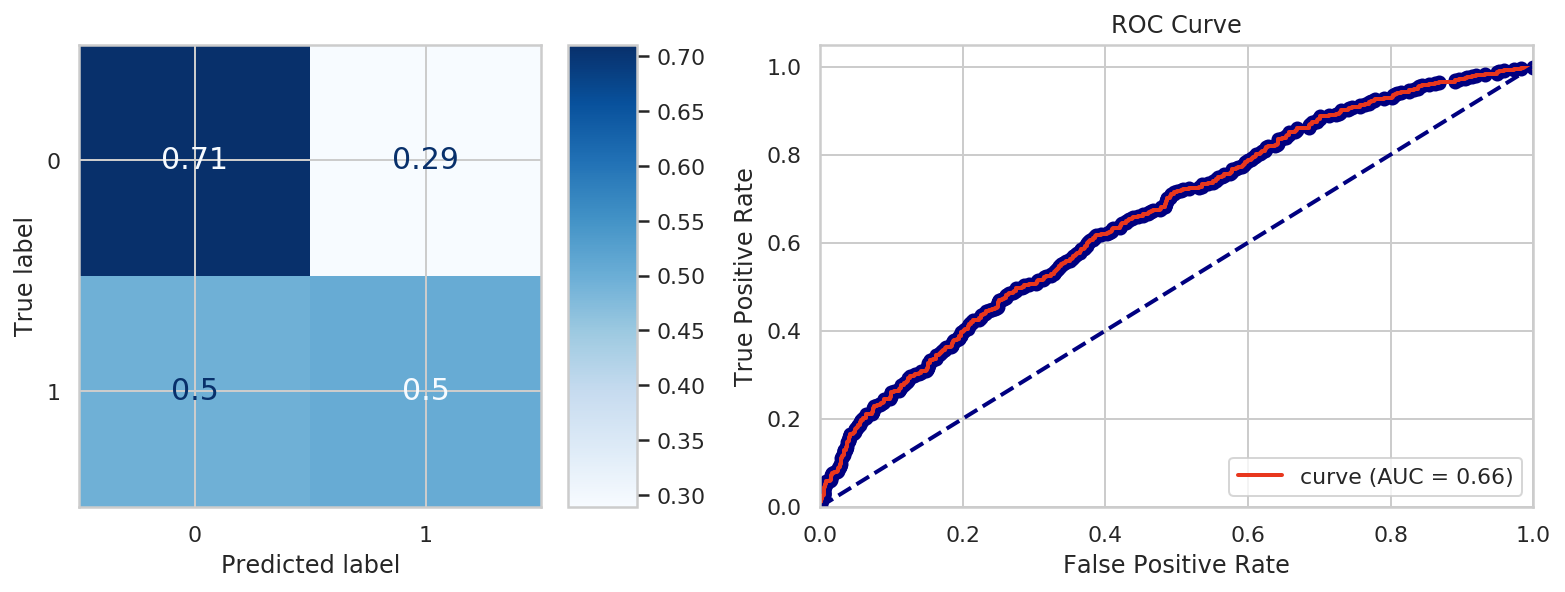

In [25]:
rf_knn_3 = RandomForestClassifier(max_depth=8, random_state=42)
rf_knn_3.fit(X_train_knn_3, y_train_knn_3)
evaluate_model(rf_knn_3, X_test_knn_3, y_test_knn_3)

#### Combined model

Same models as in the first experiment will be used. One difference is in ruler definition where index of model is defined as predicted cluster (from KMeans) instead of age group.

In [26]:
def ruler(x):
    return kmeans.predict([x])

In [27]:
cls = CombinedModel([rf_knn_1, rf_knn_2, rf_knn_3], ruler)

In [28]:
pred = cls.predict(X_test)
pred_prob = cls.predict(X_test, probabilities=True)

              precision    recall  f1-score   support

           0       0.93      0.58      0.71     18090
           1       0.16      0.63      0.25      2263

    accuracy                           0.59     20353
   macro avg       0.54      0.61      0.48     20353
weighted avg       0.84      0.59      0.66     20353

ROC AUC score: 0.648


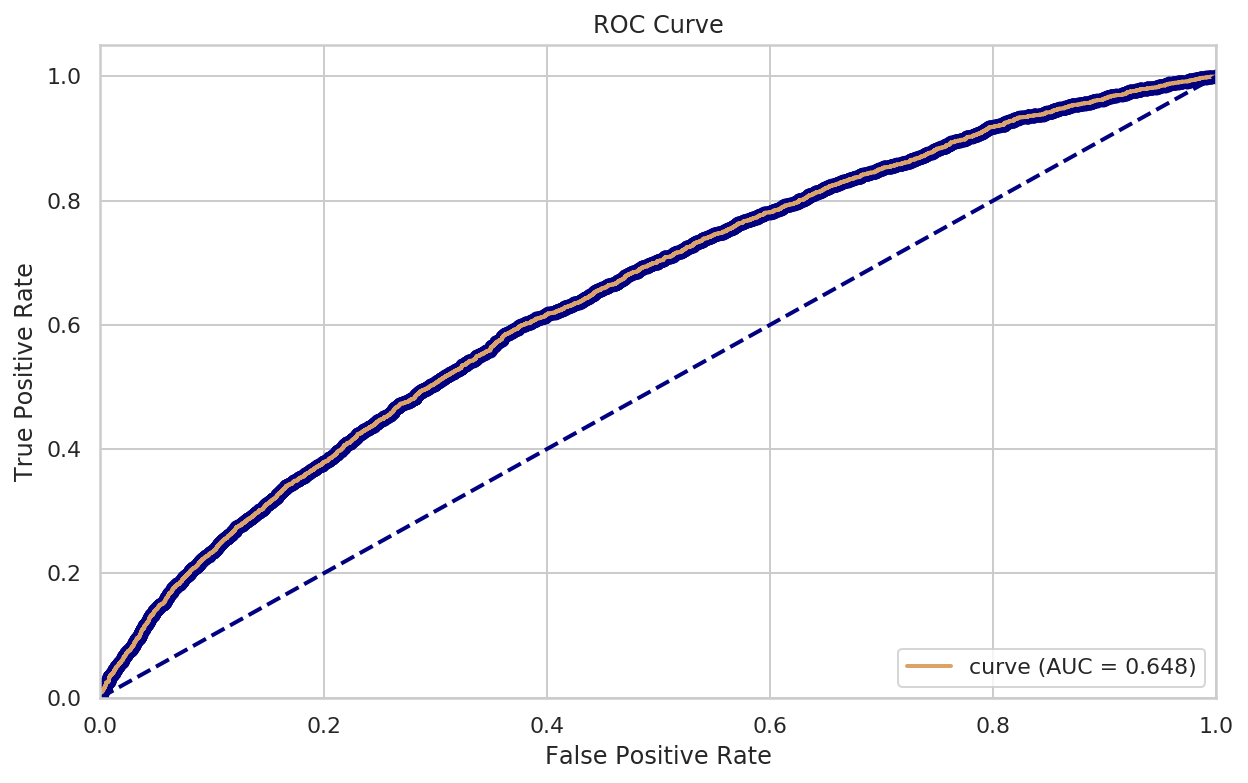

In [29]:
print(classification_report(y_test, pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, pred_prob), 3)}')
roc_auc(pred_prob, y_test);

#### Conclusion

With combination of models on individual clusters we did not achieve better results as the base model, but results are very comparable. Performance of models across clusters are almost the same, what can means that the data are not clearly divided to some groups characterized by their features. 